In [237]:
import numpy as np
import seaborn as sns
from tqdm import tqdm
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn
from sklego.meta.estimator_transformer import EstimatorTransformer
from scores.probability import crps_cdf
import pandas as pd

from src.bootstrap import max_statistic_ci, max_t_ci, max_t_transformed_ci, transform, inverse_transform

In [238]:
import warnings

warnings.filterwarnings("ignore")

In [239]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [240]:
sklearn.set_config(enable_metadata_routing=True)

In [241]:
plt.style.use("bmh")

In [242]:
class SimulationStudyTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pipeline, runs=100, random_generator=None):
        self.pipeline = pipeline
        self.runs = runs
        self.random_generator = random_generator or np.random.default_rng()

    def fit(self, X, y=None):
        self.pipeline.fit(X, y)
        return self

    def transform(self, X, y, **kwargs):
        results = []
        indexes = self.random_generator.choice(len(X), size=(self.runs, len(X)), replace=True)

        for index in tqdm(indexes, desc="Running simulations", total=self.runs): 
            X_sim = X[index]
            y_sim = y[index]

            result = self.pipeline.predict(X_sim, y_true=y_sim)

            results.append(result)

        return np.array(results)

<Axes: >

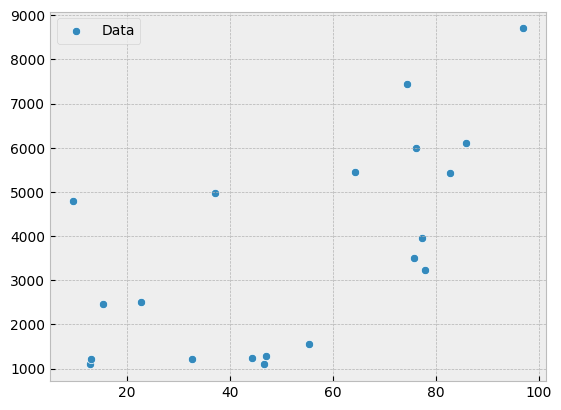

In [243]:
SAMPLES = 20
SEED = 42

rng = np.random.default_rng(SEED)
X = rng.random(size=(SAMPLES, 2)) * 100
y = np.sin(3 * X) + rng.normal(0, 5, X.shape) + X**2
y = y.mean(axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

sns.scatterplot(x=X[:, 0], y=y, label="Data")

In [244]:
import numpy as np

def bayesian_bootstrap(X, y_true, n_bootstrap=1000, random_state=None):
    rng = np.random.default_rng(random_state)
    n = len(X)
    
    samples = []

    for _ in range(n_bootstrap):
        weights = rng.dirichlet(np.ones(n))
        sample = (X.T * weights).T, y_true * weights
        samples.append(sample)

    bootstrap_X, bootstrap_y = zip(*samples)
    return np.array(bootstrap_X), np.array(bootstrap_y)

def bayesian_bootstrap_simple(X, n_bootstrap=1000, random_state=None):
    rng = np.random.default_rng(random_state)
    n = len(X)
    
    return np.array([
        X * rng.dirichlet(np.ones(n)) for _ in range(n_bootstrap)
    ])

In [245]:
class Evaluator(BaseEstimator, TransformerMixin):
    def __init__(self, metric, bootstrap_method=None, bootstrap_samples=100):
        self.metric = metric
        self.bootstrap_method = bootstrap_method or bayesian_bootstrap
        self.bootstrap_samples = bootstrap_samples

    def fit(self, X, y=None, y_true=None):
        return self

    def transform(self, X, y_true=None):
        results = []

        X_bootstraps, y_bootstraps = self.bootstrap_method(X, y_true, n_bootstrap=self.bootstrap_samples)
        for X_bootstrap, y_bootstrap in zip(X_bootstraps, y_bootstraps):
            result = self.metric(y_bootstrap, X_bootstrap)
            results.append(result)

        return np.array(results)
    
    def predict(self, X, y_true=None):
        return self.transform(X, y_true)

In [246]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

evaluator = Evaluator(metric=r2_score, bootstrap_samples=50)
evaluator.set_fit_request(y_true=True)
evaluator.set_predict_request(y_true=True)

regressor = RandomForestRegressor(n_estimators=100, random_state=SEED)

prediction_pipeline = make_pipeline(
    EstimatorTransformer(regressor),
    evaluator
)
sim_study = SimulationStudyTransformer(pipeline=prediction_pipeline, runs=500, random_generator=rng)
sim_study.fit(X_train, y_train)
simulation_data = sim_study.transform(X_test, y_test, y_true=y_test)

Running simulations: 100%|██████████| 500/500 [00:32<00:00, 15.28it/s]


In [247]:
def bootstrap_ci(data, alpha=0.05):
    lower = np.percentile(data, 100 * alpha / 2)
    upper = np.percentile(data, 100 * (1 - alpha / 2))
    return lower, upper

def format_ci(data):
    lower, upper = bootstrap_ci(data)
    return f"{data.mean():.3g} [{lower:.3g}, {upper:.3g}]"

In [248]:
lower, upper = np.apply_along_axis(bootstrap_ci, arr=simulation_data, axis=1).T

In [249]:
def interval_width(lower, upper):
    return upper - lower

def bound_stability(bound):
    return np.std(bound)

from scipy.stats import gaussian_kde
import numpy as np

def isd_from_kde(samples, grid_size=1000):
    kde = gaussian_kde(samples)
    x = np.linspace(min(samples), max(samples), grid_size)
    dx = x[1] - x[0]
    f_vals = kde(x)
    
    second_deriv = np.gradient(np.gradient(f_vals, dx), dx)
    
    isd = np.sum(second_deriv**2) * dx
    return isd

def entropy(samples, grid_size=1000):
    kde = gaussian_kde(samples)
    x = np.linspace(min(samples), max(samples), grid_size)
    dx = x[1] - x[0]
    f_vals = kde(x)

    f_norm = f_vals / np.sum(f_vals * dx) 
    return -np.sum(f_norm * np.log(f_norm + 1e-12)) * dx


def regression_mwi_score(
    y_true,
    lower,
    upper,
    confidence_level: float = 0.95
) -> float:

    y_pis = np.stack([lower, upper]).T[:, :, np.newaxis]
    y_pred_low = np.minimum(y_pis[:, 0, 0], y_pis[:, 1, 0])
    y_pred_up = np.maximum(y_pis[:, 0, 0], y_pis[:, 1, 0])

    width = np.sum(y_pred_up) - np.sum(y_pred_low)  # type: ignore
    error_above = np.sum((y_true - y_pred_up)[y_true > y_pred_up])
    error_below = np.sum((y_pred_low - y_true)[y_true < y_pred_low])
    total_error = error_above + error_below
    mwi = (width + total_error * 2 / (1 - confidence_level)) / len(lower)
    return mwi

def coverage(y_true, lower, upper):
    return np.mean((y_true >= lower) & (y_true <= upper))

In [250]:
from scipy.stats import binomtest

In [251]:
k = int(coverage(true_value, lower, upper) * len(lower))
n = len(lower)
binomtest(k, n, p=0.95).proportion_ci(confidence_level=0.95)

ConfidenceInterval(low=0.8242890050337447, high=0.8874026971422552)

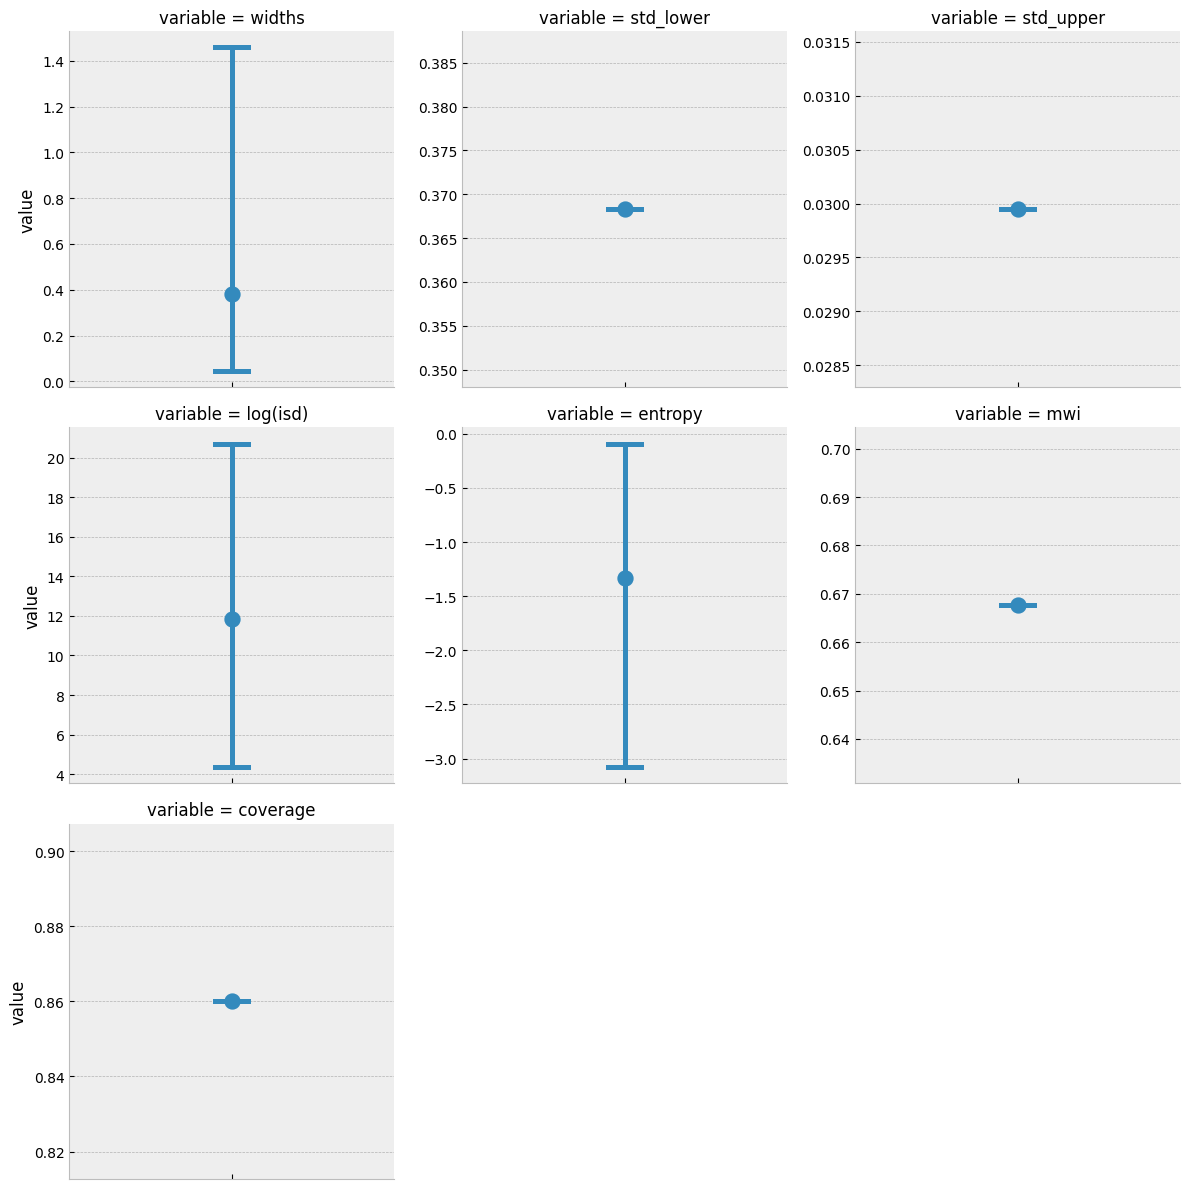

In [253]:
true_value = simulation_data.mean()
widths = interval_width(lower, upper)

metrics = pd.DataFrame({
    "widths": interval_width(lower, upper),
    "std_lower": bound_stability(lower),
    "std_upper": bound_stability(upper),
    "log(isd)": np.log(np.apply_along_axis(isd_from_kde, arr=simulation_data, axis=1).T),
    "entropy": np.apply_along_axis(entropy, arr=simulation_data, axis=1).T,
    "mwi": regression_mwi_score(true_value, lower, upper),
    "coverage": coverage(true_value, lower, upper),
})
facet = sns.FacetGrid(metrics.melt(), col="variable", sharey=False, height=4, col_wrap=3)
facet.map_dataframe(sns.pointplot, y="value", errorbar=("pi", 95), capsize=0.1)